# Abandoned attempt with kBET's R package and scib Python wrapper

We first tried to run kBET through R and a Python wrapper.

Resources:

- https://github.com/theislab/scib-pipeline/blob/b2ddba53016fb0574c37fed0c45cc0c490bdac7c/envs/create_conda_environments.sh
- https://github.com/theislab/scib-pipeline/blob/b2ddba53016fb0574c37fed0c45cc0c490bdac7c/envs/scib-pipeline-R4.0.yml
- https://github.com/theislab/scib-pipeline/blob/b2ddba53016fb0574c37fed0c45cc0c490bdac7c/envs/env_vars_activate.sh
- https://github.com/theislab/scib-pipeline/blob/b2ddba53016fb0574c37fed0c45cc0c490bdac7c/scripts/metrics/metrics.py
- https://github.com/theislab/scib/blob/77ab015254754baa5ca3380bd592bcc9207241de/docs/source/installation.rst
- https://github.com/theislab/scib/blob/77ab015254754baa5ca3380bd592bcc9207241de/scib/metrics/kbet.py
- https://github.com/theislab/scib/blob/77ab015254754baa5ca3380bd592bcc9207241de/scib/metrics/metrics.py
- https://github.com/theislab/kBET/blob/f35171dfb04c7951b8a09ac778faf7424c4b6bc0/R/kBET-utils.R#L49
- https://github.com/theislab/kBET/blob/f35171dfb04c7951b8a09ac778faf7424c4b6bc0/R/kBET.R#L328


Environment setup within our main conda environment:

```bash
conda activate cuda-env-py39; # as usual
# install R and packages
mamba install -c conda-forge r-base=4.1 r-essentials r-devtools r-stringi rpy2 -y;
R --version # 4.1.1
Rscript --version # 4.1.1
R -e 'install.packages("tidyverse",repos = "http://cran.us.r-project.org")'
Rscript -e "remotes::install_github('theislab/kBET')"
pip install 'scib[rpy2] == 1.0.4'
```

The test we ran:

```python
# set env for rpy2. see https://github.com/theislab/scib-pipeline/blob/main/envs/env_vars_activate.sh
import os, subprocess

# in notebook, conda environment belonging to the kernel is not active in env vars, so have to set CONDA_PREFIX manually:
os.environ['CONDA_PREFIX'] = os.path.expandvars("$HOME/anaconda3/envs/cuda-env-py39")

os.environ["CFLAGS"] = subprocess.getoutput("gsl-config --cflags")
os.environ["LDFLAGS"] = subprocess.getoutput("gsl-config --libs")
os.environ["LD_LIBRARY_PATH"] = os.path.expandvars("${CONDA_PREFIX}/lib/R/lib/")
os.environ["QT_QPA_PLATFORM"] = "offscreen"
os.environ["R_HOME"] = os.path.expandvars("${CONDA_PREFIX}/lib/R")
os.environ["R_LIBS"] = ""

import rpy2 # v3.5.1
import rpy2.robjects as robjects # this will fail if os.environ not set right
from scib.metrics.kbet import kBET
print(kBET.__doc__)

# go with "full" type (https://github.com/theislab/scib-pipeline/blob/75ae100cf158191ee9097750e658b2f822cc837b/scripts/metrics/metrics.py#L27)
type_ = 'full'
embed = 'X_pca'
verbose = True
scaled=False # see kBET.__doc__: make it so that 0 means optimal batch mixing and 1 means low batch mixing, as described in paper

from malid import io
from malid.datamodels import GeneLocus, TargetObsColumnEnum
adata=io.load_fold_embeddings(
    fold_id=0,
    fold_label='test',
    gene_locus=GeneLocus.BCR,
    target_obs_column=TargetObsColumnEnum.disease
)
batch_key = "study_name"
label_key = "disease"
kbet_scores_df = kBET(
    adata=adata,
    batch_key=batch_key,
    label_key=label_key,
    type_=type_,
    embed=embed,
    scaled=scaled,
    verbose=verbose,
    return_df=True
)
kbet_scores_df
final_score = np.nanmean(kbet_scores_df["kBET"])
final_score = 1 - final_score if scaled else final_score
final_score
```

The problem: very slow compute. Our datasets are ~15x the max dataset size at which the scib benchmarking code disables kBET.

# Reimplementation

Instead we will reimplement based on this partial PR: https://github.com/scverse/scanpy/pull/364

kBET:

- from https://www.nature.com/articles/s41592-018-0254-1:

> In a dataset with replicates and no batch effects, the proportions of the batch labels in any neighborhood do not differ from the global distribution. In a replicated dataset with batch effects, data points from respective batches tend to cluster with their ‘peers’, and batch label proportions differ considerably between arbitrarily chosen neighborhoods

> Intuitively, a replicated experiment is well mixed if a subset of neighboring samples (e.g., single-cell transcriptomic data points) has the same distribution of batch labels as the full dataset.
>
> In contrast, a repetition of the experiment with some bias is expected to yield a skewed distribution of batch labels across the dataset.
>
> kBET uses a χ2-based test for random neighborhoods of fixed size to determine whether they are well mixed, followed by averaging of the binary test results to return an overall rejection rate. This result is easy to interpret: low rejection rates imply well-mixed replicates.

- from https://www.nature.com/articles/s41592-021-01336-8:

> The kBET algorithm (v.0.99.6, release 4c9dafa) determines whether the label composition of a k nearest neighborhood of a cell is similar to the expected (global) label composition. The test is repeated for a random subset of cells, and the results are summarized as a rejection rate over all tested neighborhoods.

> We applied kBET separately on the batch variable for each cell identity label. Using the kBET defaults, a k equal to the median of the number of cells per batch within each label was used for this computation. Additionally, we set the minimum and maximum thresholds of k to 10 and 100, respectively. As kNN graphs that have been subset by cell identity labels may no longer be connected, we computed kBET per connected component. If >25% of cells were assigned to connected components too small for kBET computation (smaller than k × 3), we assigned a kBET score of 1 to denote poor batch removal. Subsequently, kBET scores for each label were averaged and subtracted from 1 to give a final kBET score.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns
from scipy.stats import chisquare
from statsmodels.stats.multitest import multipletests
import anndata
from kdict import kdict
import gc
from IPython.display import display

In [2]:
from malid import io, helpers, logger, config
from malid.datamodels import (
    map_cross_validation_split_strategy_to_default_target_obs_column,
)

In [3]:
# Use GPU for kNN construction and queries
import choosegpu

choosegpu.configure_gpu(enable=True)

# Then import relevant methods
from malid.knn import _fit_knn_index, _get_neighbors

{"message": "init", "time": "2024-01-08T09:05:13.966228"}


In [4]:
target_obs_column = map_cross_validation_split_strategy_to_default_target_obs_column[
    config.cross_validation_split_strategy
]

In [5]:
def kbet(
    adata: anndata.AnnData,
    batch_key: str,
    label_key: str,
    significance_threshold_alpha=0.05,
):
    """
    kBET reimplementation.
    Returns average-rejection-rate averages across labels; average rejection rate by label; all corrected p values for each label (not in same order as anndata obs)
    """
    rejection_rates_by_label = {}
    corrected_p_values_by_label = {}

    # Group by label_key
    # kBET is computed separately for each cell identity label, and only considers connections between cells of the same identity.
    for label, adata_label in helpers.anndata_groupby_obs(
        adata, label_key, observed=True
    ):
        batch_sizes = adata_label.obs[batch_key].value_counts()
        if batch_sizes.index.shape[0] == 1:
            logger.info(
                f"Skipping {label_key}={label} because it has only one {batch_key} batch"
            )
            continue

        # If any batch size is extremely large, subsample it.
        MAX_BATCH_SIZE = 2000000  # 2 million

        # Create a list to store obsnames to remove from the oversized groups
        # See also https://github.com/scverse/scanpy/issues/987#issuecomment-1387199509 for another approach
        indices_to_remove = []

        if adata_label.obs_names.duplicated().any():
            raise ValueError("Obs names must be unique")

        for batch, batch_size in batch_sizes.items():
            if batch_size > MAX_BATCH_SIZE:
                logger.info(
                    f"Subsampling {label_key}={label} because {batch_key}={batch} has {batch_size} entries which exceeds the maximum of {MAX_BATCH_SIZE}"
                )
                # Determine the number of entries to remove
                remove_count = batch_size - MAX_BATCH_SIZE

                # Randomly select indices to remove
                indices_to_remove.append(
                    np.random.choice(
                        adata_label.obs_names[adata_label.obs[batch_key] == batch],
                        size=remove_count,
                        replace=False,
                    )
                )

        if len(indices_to_remove) > 0:
            # Exclude the indices to remove from the adata object
            adata_label = adata_label[
                ~adata_label.obs.index.isin(np.hstack(indices_to_remove))
            ]

            # Recompute batch_sizes
            batch_sizes = adata_label.obs[batch_key].value_counts()
        del indices_to_remove
        gc.collect()

        # Choose neighborhood size, based on heuristics in kBET and scib
        neighborhood_size = batch_sizes.mean() // 4
        neighborhood_size = min([50, max([10, neighborhood_size])])
        # We also considered these alternative options:
        # "a k equal to the median of the number of cells per batch within each label was used for this computation.
        # Additionally, we set the minimum and maximum thresholds of k to 10 and 100, respectively."
        # We also saw clipping between 10 and int(batch_sizes.mean() * 3/4)
        # None of these make too much sense for our case where we have batch sizes in the tens of thousands
        # Everything will default to 50. (70 was the chosen default in some implementations we saw)

        # But we are keeping this sanity-check on the size from other implementations, though it doesn't seem that important:
        size_max = np.iinfo(np.int32).max
        if neighborhood_size * adata_label.shape[0] >= size_max:
            neighborhood_size = size_max // adata_label.shape[0]

        # Unlike kBET, we are just going to run once with a fixed neighborhood size
        logger.info(
            f"Running kBET on {label_key}={label} with neighborhood size {neighborhood_size} (based on batch sizes {batch_sizes.to_dict()})"
        )

        # Compute separate kNN graph for each identity subset
        # Note: the kBET and scib-benchmarking implementations compute a global kNN graph with cells of all identity labels, then subset it for each cell identity label. This means they have to deal with edge cases when the graph is no longer connected, so it looks like they end up running on each strongly connected component separately.
        # It seems like it’d be easier to just build a separate kNN graph for each cell identity label. However, this might connect cells that would otherwise be disconnected if they live in neighborhoods dominated by other cell identity labels. For the purpose of measuring batch integration within each cell identity label, I’m not sure this is a problem.
        # We will instead build separate kNN graphs for each identity-label subset of cells

        # Build kNN index
        logger.info("Fitting kNN index...")
        knn_index = _fit_knn_index(X=adata_label.obsm["X_pca"])

        # Query kNN index
        logger.info("Querying kNN index...")
        neighbor_links_df = _get_neighbors(
            knn_index=knn_index,
            data_X_contiguous=adata_label.obsm["X_pca"],
            n_neighbors=neighborhood_size,
        )

        logger.info("Computing neighborhood statistics...")

        # Note when merging:
        # center_id and neighbor_id are integer ilocs (within adata_label), not obs_names / locs

        # prepare to merge by iloc later: create sequence_info that includes the integer index
        sequence_info = adata_label.obs[[batch_key, label_key]].reset_index(drop=True)
        # make columns catgegorical:
        sequence_info[batch_key] = sequence_info[batch_key].astype("category")
        sequence_info[label_key] = sequence_info[label_key].astype("category")

        # Merge in neighbor info
        # neighbor_id is an iloc within adata_label
        neighbor_links_df = pd.merge(
            neighbor_links_df,
            sequence_info.rename(columns=lambda s: f"neighbor_{s}"),
            how="left",
            left_on="neighbor_id",
            right_index=True,
            validate="m:1",
        )

        # merge in center info
        # center_id is a iloc within adata_label
        neighbor_links_df = pd.merge(
            neighbor_links_df,
            sequence_info.rename(columns=lambda s: f"center_{s}"),
            how="left",
            left_on="center_id",
            right_index=True,
            validate="m:1",
        )

        ## Compare label composition of k-nearest neighborhood of each sequence versus the expected (global) label composition

        ## Get expected neighborhood composition from global values: normalized value counts * chosen k neighbors
        expected_frequencies = (batch_sizes / batch_sizes.sum()) * neighborhood_size
        logger.info(
            f"kBET on {label_key}={label} with neighborhood size {neighborhood_size} has expected frequencies: {expected_frequencies.to_dict()}"
        )

        ## Get observed frequencies for each cell

        # First, confirm we computed the right number of neighbors
        total_num_neighbors = (
            neighbor_links_df.groupby(["center_id"], observed=True)
            .size()
            .rename("total_num_neighbors")
        )
        assert all(total_num_neighbors == neighborhood_size)
        # Also sanity check that all identity labels are the same
        assert (
            neighbor_links_df[f"center_{label_key}"]
            == neighbor_links_df[f"neighbor_{label_key}"]
        ).all()
        assert (neighbor_links_df[f"center_{label_key}"] == label).all()

        # Get neighborhood batch frequencies for each cell
        # https://stackoverflow.com/a/39132900/130164
        observed_neighbor_batch_frequencies = (
            neighbor_links_df.groupby(
                ["center_id", f"neighbor_{batch_key}"], observed=True
            )
            .size()
            .unstack(fill_value=0)
        )

        # rearrange order to match
        assert set(observed_neighbor_batch_frequencies.columns) == set(
            expected_frequencies.index
        )
        expected_frequencies = expected_frequencies.loc[
            observed_neighbor_batch_frequencies.columns
        ]

        # Compute test statistic for each cell
        # "kBET uses a χ2-based test for random neighborhoods of fixed size to determine whether they are well mixed,
        # followed by averaging of the binary test results to return an overall rejection rate.
        # This result is easy to interpret: low rejection rates imply well-mixed replicates."
        chisquared_test_statistic, p_values_uncorrected = chisquare(
            f_obs=observed_neighbor_batch_frequencies,
            f_exp=expected_frequencies,
            axis=1,
        )

        # Correct for multiple hypothesis testing
        is_wellmixed_null_hypothesis_rejected, corrected_p_values, _, _ = multipletests(
            pvals=p_values_uncorrected,
            alpha=significance_threshold_alpha,
            method="fdr_tsbh",
        )
        # is_wellmixed_null_hypothesis_rejected is a numpy array of booleans
        rejection_rate = is_wellmixed_null_hypothesis_rejected.mean()

        # Store result for each label
        rejection_rates_by_label[label] = rejection_rate
        # note that corrected_p_values are not in order of obsnames and should thus not be glued onto adata.obs or adata_label.obs
        corrected_p_values_by_label[label] = corrected_p_values

    # Aggregate the results across labels
    # "Subsequently, kBET scores for each label were averaged and subtracted from 1 to give a final kBET score."
    # ^ This subtraction seems to only be in scib benchmarking and the scanpy partial PR.
    # Really we should keep it as rejection rate, so 0 means null hypothesis was not rejected much, suggesting the well-mixed hypothesis holds.

    # Returns average-rejection-rate averages across labels; average rejection rate by label; all corrected p values for each label (not in same order as anndata obs)
    return (
        np.mean(list(rejection_rates_by_label.values())),
        rejection_rates_by_label,
        corrected_p_values_by_label,
    )

In [6]:
# kBET will be computed amongst all sequences with same [label_key]
label_key = target_obs_column.value.obs_column_name

# kBET will compute whether [batch_key] batches are well-mixed within each [label_key]
batch_key = "study_name"

# run on:
fold_label = "test"

# plot labels
xlabel = "kBET χ² test corrected p-value"
ylabel = target_obs_column.value.obs_column_name

{"message": "Running on GeneLocus.BCR, fold 0-test", "time": "2024-01-08T09:05:19.221393"}


{"message": "Caching network file to local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20231027/in_house_peak_disease_timepoints/embedded/esm2_cdr3/anndatas_scaled/BCR/fold.0.test.h5ad -> /srv/scratch/maximz/cache/3d20a5c23fcc35b23cb822073f9cb2d6b0bebaee62c3a334176a736d.0.test.h5ad", "time": "2024-01-08T09:05:19.229383"}


Only considering the two last: ['.test', '.h5ad'].


Only considering the two last: ['.test', '.h5ad'].


disease             study_name                                          
HIV                 HIV                                                      774292
Healthy/Background  Diabetes biobank                                          14974
                    HIV                                                      234287
                    Healthy-StanfordBloodCenter                             1392350
                    Healthy-StanfordBloodCenter_included-in-resequencing     572154
                    Lupus                                                    137798
                    New Lupus Paxgene                                        116330
                    New Lupus RNA                                             67472
                    healthy_children                                         297729
Lupus               Lupus                                                    166082
                    Lupus Pediatric                                          827281
   

{"message": "Skipping disease=HIV because it has only one study_name batch", "time": "2024-01-08T09:11:56.054777"}


{"message": "Running kBET on disease=Healthy/Background with neighborhood size 50 (based on batch sizes {'Healthy-StanfordBloodCenter': 1392350, 'Healthy-StanfordBloodCenter_included-in-resequencing': 572154, 'healthy_children': 297729, 'HIV': 234287, 'Lupus': 137798, 'New Lupus Paxgene': 116330, 'New Lupus RNA': 67472, 'Diabetes biobank': 14974})", "time": "2024-01-08T09:12:04.198146"}


{"message": "Fitting kNN index...", "time": "2024-01-08T09:12:04.199975"}


{"message": "Querying kNN index...", "time": "2024-01-08T09:12:05.449151"}


{"message": "Computing neighborhood statistics...", "time": "2024-01-08T09:17:49.358247"}


{"message": "kBET on disease=Healthy/Background with neighborhood size 50 has expected frequencies: {'Healthy-StanfordBloodCenter': 24.572958045161933, 'Healthy-StanfordBloodCenter_included-in-resequencing': 10.097688251784092, 'healthy_children': 5.254485025911601, 'HIV': 4.134825741750891, 'Lupus': 2.4319348387310833, 'New Lupus Paxgene': 2.0530557757702357, 'New Lupus RNA': 1.1907829390765008, 'Diabetes biobank': 0.26426938181366383}", "time": "2024-01-08T09:19:15.065649"}


{"message": "Running kBET on disease=Lupus with neighborhood size 50 (based on batch sizes {'Lupus Pediatric': 827281, 'Lupus': 166082, 'New Lupus RNA': 119823, 'New Lupus Paxgene': 103204})", "time": "2024-01-08T09:19:56.749435"}


{"message": "Fitting kNN index...", "time": "2024-01-08T09:19:56.752754"}


{"message": "Querying kNN index...", "time": "2024-01-08T09:19:57.237461"}


{"message": "Computing neighborhood statistics...", "time": "2024-01-08T09:21:03.405665"}


{"message": "kBET on disease=Lupus with neighborhood size 50 has expected frequencies: {'Lupus Pediatric': 34.00558209127007, 'Lupus': 6.826840075962479, 'New Lupus RNA': 4.925352888465048, 'New Lupus Paxgene': 4.242224944302403}", "time": "2024-01-08T09:21:35.136880"}


{"message": "Running kBET on disease=Covid19 with neighborhood size 50 (based on batch sizes {'Covid19-buffycoat': 137093, 'Covid19-Stanford': 77699, 'Covid19-Seattle': 41024})", "time": "2024-01-08T09:21:49.148942"}


{"message": "Fitting kNN index...", "time": "2024-01-08T09:21:49.150214"}


{"message": "Querying kNN index...", "time": "2024-01-08T09:21:49.248555"}


{"message": "Computing neighborhood statistics...", "time": "2024-01-08T09:21:53.609909"}


{"message": "kBET on disease=Covid19 with neighborhood size 50 has expected frequencies: {'Covid19-buffycoat': 26.795235638114896, 'Covid19-Stanford': 15.186501235262845, 'Covid19-Seattle': 8.01826312662226}", "time": "2024-01-08T09:21:58.478960"}


{"message": "Skipping disease=Influenza because it has only one study_name batch", "time": "2024-01-08T09:22:00.874086"}


{"message": "Skipping disease=T1D because it has only one study_name batch", "time": "2024-01-08T09:22:01.748245"}


kBET result for GeneLocus.BCR, fold 0-test: 0.32465 average of average rejection rate by label
Average rejection rates for each label


,disease,average_rejection_rate,fold_id,fold_label,gene_locus
0,Healthy/Background,0.362727,0,test,BCR
1,Lupus,0.164288,0,test,BCR
2,Covid19,0.446931,0,test,BCR


{"message": "Running on GeneLocus.BCR, fold 1-test", "time": "2024-01-08T09:22:08.683932"}


{"message": "Caching network file to local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20231027/in_house_peak_disease_timepoints/embedded/esm2_cdr3/anndatas_scaled/BCR/fold.1.test.h5ad -> /srv/scratch/maximz/cache/a8ec2a8d7e77231cb7a3b56a8ab70b4db67ff80a760932bfa7818be7.1.test.h5ad", "time": "2024-01-08T09:22:08.709262"}


************************************************************


Only considering the two last: ['.test', '.h5ad'].


Only considering the two last: ['.test', '.h5ad'].


disease             study_name                                          
Healthy/Background  Diabetes biobank                                          7979
                    HIV                                                     339711
                    Healthy-StanfordBloodCenter                             612114
                    Healthy-StanfordBloodCenter_included-in-resequencing    901105
                    Lupus                                                   113548
                    New Lupus RNA                                            15412
                    healthy_children                                        370772
HIV                 HIV                                                     920874
Lupus               Lupus                                                   218307
                    Lupus Pediatric                                         816698
                    New Lupus Paxgene                                        69876
              

{"message": "Running kBET on disease=Healthy/Background with neighborhood size 50 (based on batch sizes {'Healthy-StanfordBloodCenter_included-in-resequencing': 901105, 'Healthy-StanfordBloodCenter': 612114, 'healthy_children': 370772, 'HIV': 339711, 'Lupus': 113548, 'New Lupus RNA': 15412, 'Diabetes biobank': 7979})", "time": "2024-01-08T09:28:40.369279"}


{"message": "Fitting kNN index...", "time": "2024-01-08T09:28:40.372410"}


{"message": "Querying kNN index...", "time": "2024-01-08T09:28:41.243408"}


{"message": "Computing neighborhood statistics...", "time": "2024-01-08T09:32:39.774584"}


{"message": "kBET on disease=Healthy/Background with neighborhood size 50 has expected frequencies: {'Healthy-StanfordBloodCenter_included-in-resequencing': 19.08602366899499, 'Healthy-StanfordBloodCenter': 12.96499552452067, 'healthy_children': 7.853205972445619, 'HIV': 7.195312629069816, 'Lupus': 2.4050247369252675, 'New Lupus RNA': 0.32643676018505147, 'Diabetes biobank': 0.16900070785858587}", "time": "2024-01-08T09:33:49.974412"}


{"message": "Skipping disease=HIV because it has only one study_name batch", "time": "2024-01-08T09:34:19.138412"}


{"message": "Running kBET on disease=Lupus with neighborhood size 50 (based on batch sizes {'Lupus Pediatric': 816698, 'Lupus': 218307, 'New Lupus RNA': 73326, 'New Lupus Paxgene': 69876})", "time": "2024-01-08T09:34:22.862072"}


{"message": "Fitting kNN index...", "time": "2024-01-08T09:34:22.863661"}


{"message": "Querying kNN index...", "time": "2024-01-08T09:34:23.210862"}


{"message": "Computing neighborhood statistics...", "time": "2024-01-08T09:35:25.614886"}


{"message": "kBET on disease=Lupus with neighborhood size 50 has expected frequencies: {'Lupus Pediatric': 34.6585107710275, 'Lupus': 9.264373747567278, 'New Lupus RNA': 3.1117621945888967, 'New Lupus Paxgene': 2.9653532868163235}", "time": "2024-01-08T09:35:56.094740"}


{"message": "Running kBET on disease=Covid19 with neighborhood size 50 (based on batch sizes {'Covid19-Stanford': 197211, 'Covid19-Seattle': 125489, 'Covid19-buffycoat': 13663})", "time": "2024-01-08T09:36:09.425930"}


{"message": "Fitting kNN index...", "time": "2024-01-08T09:36:09.430259"}


{"message": "Querying kNN index...", "time": "2024-01-08T09:36:09.581403"}


{"message": "Computing neighborhood statistics...", "time": "2024-01-08T09:36:16.323944"}


{"message": "kBET on disease=Covid19 with neighborhood size 50 has expected frequencies: {'Covid19-Stanford': 29.31520410984561, 'Covid19-Seattle': 18.653805561253765, 'Covid19-buffycoat': 2.0309903289006224}", "time": "2024-01-08T09:36:22.597100"}


{"message": "Skipping disease=Influenza because it has only one study_name batch", "time": "2024-01-08T09:36:25.864331"}


{"message": "Skipping disease=T1D because it has only one study_name batch", "time": "2024-01-08T09:36:26.909714"}


kBET result for GeneLocus.BCR, fold 1-test: 0.27599 average of average rejection rate by label
Average rejection rates for each label


,disease,average_rejection_rate,fold_id,fold_label,gene_locus
0,Healthy/Background,0.273227,1,test,BCR
1,Lupus,0.172976,1,test,BCR
2,Covid19,0.381760,1,test,BCR


{"message": "Running on GeneLocus.BCR, fold 2-test", "time": "2024-01-08T09:36:32.755828"}


{"message": "Caching network file to local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20231027/in_house_peak_disease_timepoints/embedded/esm2_cdr3/anndatas_scaled/BCR/fold.2.test.h5ad -> /srv/scratch/maximz/cache/49ad448986ba6c629bddd18a775b224b397f41d526a744104498b992.2.test.h5ad", "time": "2024-01-08T09:36:32.783745"}


************************************************************


Only considering the two last: ['.test', '.h5ad'].


Only considering the two last: ['.test', '.h5ad'].


disease             study_name                                          
HIV                 HIV                                                     1029486
Healthy/Background  Diabetes biobank                                           8617
                    HIV                                                      245479
                    Healthy-StanfordBloodCenter                             1275549
                    Healthy-StanfordBloodCenter_included-in-resequencing     127559
                    Lupus                                                    108610
                    New Lupus RNA                                             41257
                    healthy_children                                         450553
Lupus               Lupus                                                    127067
                    Lupus Pediatric                                          583117
                    New Lupus Paxgene                                        110770
   

{"message": "Skipping disease=HIV because it has only one study_name batch", "time": "2024-01-08T09:42:42.283628"}


{"message": "Running kBET on disease=Healthy/Background with neighborhood size 50 (based on batch sizes {'Healthy-StanfordBloodCenter': 1275549, 'healthy_children': 450553, 'HIV': 245479, 'Healthy-StanfordBloodCenter_included-in-resequencing': 127559, 'Lupus': 108610, 'New Lupus RNA': 41257, 'Diabetes biobank': 8617})", "time": "2024-01-08T09:42:53.248452"}


{"message": "Fitting kNN index...", "time": "2024-01-08T09:42:53.249621"}


{"message": "Querying kNN index...", "time": "2024-01-08T09:42:53.857909"}


{"message": "Computing neighborhood statistics...", "time": "2024-01-08T09:46:32.806295"}


{"message": "kBET on disease=Healthy/Background with neighborhood size 50 has expected frequencies: {'Healthy-StanfordBloodCenter': 28.24981042015854, 'healthy_children': 9.978477372671446, 'HIV': 5.436667044645167, 'Healthy-StanfordBloodCenter_included-in-resequencing': 2.825071845444591, 'Lupus': 2.4054049744332984, 'New Lupus RNA': 0.9137261120540887, 'Diabetes biobank': 0.1908422305928711}", "time": "2024-01-08T09:47:36.118075"}


{"message": "Running kBET on disease=Lupus with neighborhood size 50 (based on batch sizes {'Lupus Pediatric': 583117, 'Lupus': 127067, 'New Lupus Paxgene': 110770, 'New Lupus RNA': 100539})", "time": "2024-01-08T09:48:04.940021"}


{"message": "Fitting kNN index...", "time": "2024-01-08T09:48:04.942575"}


{"message": "Querying kNN index...", "time": "2024-01-08T09:48:05.217307"}


{"message": "Computing neighborhood statistics...", "time": "2024-01-08T09:48:44.562068"}


{"message": "kBET on disease=Lupus with neighborhood size 50 has expected frequencies: {'Lupus Pediatric': 31.63979541895598, 'Lupus': 6.894626437748307, 'New Lupus Paxgene': 6.010354934871995, 'New Lupus RNA': 5.455223208423721}", "time": "2024-01-08T09:49:07.257297"}


{"message": "Running kBET on disease=Covid19 with neighborhood size 50 (based on batch sizes {'Covid19-Stanford': 123876, 'Covid19-Seattle': 106463, 'Covid19-buffycoat': 104031})", "time": "2024-01-08T09:49:18.240790"}


{"message": "Fitting kNN index...", "time": "2024-01-08T09:49:18.245842"}


{"message": "Querying kNN index...", "time": "2024-01-08T09:49:18.343849"}


{"message": "Computing neighborhood statistics...", "time": "2024-01-08T09:49:25.093858"}


{"message": "kBET on disease=Covid19 with neighborhood size 50 has expected frequencies: {'Covid19-Stanford': 18.52379100995903, 'Covid19-Seattle': 15.919938989741903, 'Covid19-buffycoat': 15.556270000299069}", "time": "2024-01-08T09:49:32.037294"}


{"message": "Skipping disease=Influenza because it has only one study_name batch", "time": "2024-01-08T09:49:35.401917"}


{"message": "Skipping disease=T1D because it has only one study_name batch", "time": "2024-01-08T09:49:36.243036"}


kBET result for GeneLocus.BCR, fold 2-test: 0.34195 average of average rejection rate by label
Average rejection rates for each label


,disease,average_rejection_rate,fold_id,fold_label,gene_locus
0,Healthy/Background,0.307194,2,test,BCR
1,Lupus,0.223200,2,test,BCR
2,Covid19,0.495463,2,test,BCR


{"message": "Running on GeneLocus.TCR, fold 0-test", "time": "2024-01-08T09:49:41.847129"}


{"message": "Caching network file to local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20231027/in_house_peak_disease_timepoints/embedded/esm2_cdr3/anndatas_scaled/TCR/fold.0.test.h5ad -> /srv/scratch/maximz/cache/41935c853da5d38d5d39cd74a38bd148951d1e8ded05e20393494c35.0.test.h5ad", "time": "2024-01-08T09:49:41.870960"}


************************************************************


Only considering the two last: ['.test', '.h5ad'].


Only considering the two last: ['.test', '.h5ad'].


disease             study_name                                          
HIV                 HIV                                                     1056122
Healthy/Background  Diabetes biobank                                          27260
                    HIV                                                      465091
                    Healthy-StanfordBloodCenter                             1829837
                    Healthy-StanfordBloodCenter_included-in-resequencing     656357
                    New Lupus Paxgene                                        377708
                    New Lupus RNA                                             51998
                    healthy_children                                        1000190
Covid19             Covid19-Stanford                                         156847
                    Covid19-buffycoat                                        132755
Lupus               Lupus Pediatric                                          918950
   

{"message": "Skipping disease=HIV because it has only one study_name batch", "time": "2024-01-08T10:00:22.914066"}


{"message": "Running kBET on disease=Healthy/Background with neighborhood size 50 (based on batch sizes {'Healthy-StanfordBloodCenter': 1829837, 'healthy_children': 1000190, 'Healthy-StanfordBloodCenter_included-in-resequencing': 656357, 'HIV': 465091, 'New Lupus Paxgene': 377708, 'New Lupus RNA': 51998, 'Diabetes biobank': 27260})", "time": "2024-01-08T10:01:09.467987"}


{"message": "Fitting kNN index...", "time": "2024-01-08T10:01:09.470201"}


{"message": "Querying kNN index...", "time": "2024-01-08T10:01:10.661719"}


{"message": "Computing neighborhood statistics...", "time": "2024-01-08T10:15:31.922872"}


{"message": "kBET on disease=Healthy/Background with neighborhood size 50 has expected frequencies: {'Healthy-StanfordBloodCenter': 20.75378801712442, 'healthy_children': 11.344032958590123, 'Healthy-StanfordBloodCenter_included-in-resequencing': 7.444321019607612, 'HIV': 5.275005381721112, 'New Lupus Paxgene': 4.283918056292463, 'New Lupus RNA': 0.5897549723360254, 'Diabetes biobank': 0.3091795943282444}", "time": "2024-01-08T10:17:52.964766"}


{"message": "Running kBET on disease=Covid19 with neighborhood size 50 (based on batch sizes {'Covid19-Stanford': 156847, 'Covid19-buffycoat': 132755})", "time": "2024-01-08T10:18:53.276017"}


{"message": "Fitting kNN index...", "time": "2024-01-08T10:18:53.279104"}


{"message": "Querying kNN index...", "time": "2024-01-08T10:18:53.353626"}


{"message": "Computing neighborhood statistics...", "time": "2024-01-08T10:18:58.691802"}


{"message": "kBET on disease=Covid19 with neighborhood size 50 has expected frequencies: {'Covid19-Stanford': 27.079750830450067, 'Covid19-buffycoat': 22.920249169549933}", "time": "2024-01-08T10:19:04.080081"}


{"message": "Running kBET on disease=Lupus with neighborhood size 50 (based on batch sizes {'Lupus Pediatric': 918950, 'New Lupus Paxgene': 375474, 'New Lupus RNA': 117922})", "time": "2024-01-08T10:19:12.365163"}


{"message": "Fitting kNN index...", "time": "2024-01-08T10:19:12.369424"}


{"message": "Querying kNN index...", "time": "2024-01-08T10:19:12.786973"}


{"message": "Computing neighborhood statistics...", "time": "2024-01-08T10:20:40.727878"}


{"message": "kBET on disease=Lupus with neighborhood size 50 has expected frequencies: {'Lupus Pediatric': 32.53275047332594, 'New Lupus Paxgene': 13.29256428665497, 'New Lupus RNA': 4.174685240019089}", "time": "2024-01-08T10:21:17.932764"}


{"message": "Skipping disease=Influenza because it has only one study_name batch", "time": "2024-01-08T10:21:30.731028"}


{"message": "Skipping disease=T1D because it has only one study_name batch", "time": "2024-01-08T10:21:32.866248"}


kBET result for GeneLocus.TCR, fold 0-test: 0.05108 average of average rejection rate by label
Average rejection rates for each label


,disease,average_rejection_rate,fold_id,fold_label,gene_locus
0,Healthy/Background,0.070744,0,test,TCR
1,Covid19,0.046122,0,test,TCR
2,Lupus,0.036386,0,test,TCR


{"message": "Running on GeneLocus.TCR, fold 1-test", "time": "2024-01-08T10:21:42.472090"}


{"message": "Caching network file to local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20231027/in_house_peak_disease_timepoints/embedded/esm2_cdr3/anndatas_scaled/TCR/fold.1.test.h5ad -> /srv/scratch/maximz/cache/c5bcf716b249e7555aa96e56969f7f543c4a94532ed01bbf7f05aeb2.1.test.h5ad", "time": "2024-01-08T10:21:42.491917"}


************************************************************


Only considering the two last: ['.test', '.h5ad'].


Only considering the two last: ['.test', '.h5ad'].


disease             study_name                                          
Healthy/Background  Diabetes biobank                                          22193
                    HIV                                                      518564
                    Healthy-StanfordBloodCenter                              923870
                    Healthy-StanfordBloodCenter_included-in-resequencing    1277421
                    New Lupus RNA                                             11216
                    healthy_children                                        1349332
HIV                 HIV                                                     1016778
Covid19             Covid19-Stanford                                         279887
                    Covid19-buffycoat                                         15404
Lupus               Lupus Pediatric                                          767165
                    New Lupus Paxgene                                        123275
   

{"message": "Running kBET on disease=Healthy/Background with neighborhood size 50 (based on batch sizes {'healthy_children': 1349332, 'Healthy-StanfordBloodCenter_included-in-resequencing': 1277421, 'Healthy-StanfordBloodCenter': 923870, 'HIV': 518564, 'Diabetes biobank': 22193, 'New Lupus RNA': 11216})", "time": "2024-01-08T10:32:17.175086"}


{"message": "Fitting kNN index...", "time": "2024-01-08T10:32:17.177902"}


{"message": "Querying kNN index...", "time": "2024-01-08T10:32:18.284836"}


{"message": "Computing neighborhood statistics...", "time": "2024-01-08T10:44:05.967890"}


{"message": "kBET on disease=Healthy/Background with neighborhood size 50 has expected frequencies: {'healthy_children': 16.444855891245446, 'Healthy-StanfordBloodCenter_included-in-resequencing': 15.568447392821522, 'Healthy-StanfordBloodCenter': 11.259578081780413, 'HIV': 6.319949612391763, 'Diabetes biobank': 0.2704750845562176, 'New Lupus RNA': 0.13669393720463824}", "time": "2024-01-08T10:46:16.707729"}


{"message": "Skipping disease=HIV because it has only one study_name batch", "time": "2024-01-08T10:47:11.020299"}


{"message": "Running kBET on disease=Covid19 with neighborhood size 50 (based on batch sizes {'Covid19-Stanford': 279887, 'Covid19-buffycoat': 15404})", "time": "2024-01-08T10:47:12.329920"}


{"message": "Fitting kNN index...", "time": "2024-01-08T10:47:12.331561"}


{"message": "Querying kNN index...", "time": "2024-01-08T10:47:12.408070"}


{"message": "Computing neighborhood statistics...", "time": "2024-01-08T10:47:17.926876"}


{"message": "kBET on disease=Covid19 with neighborhood size 50 has expected frequencies: {'Covid19-Stanford': 47.391725450487826, 'Covid19-buffycoat': 2.608274549512176}", "time": "2024-01-08T10:47:23.407543"}


{"message": "Running kBET on disease=Lupus with neighborhood size 50 (based on batch sizes {'Lupus Pediatric': 767165, 'New Lupus RNA': 197191, 'New Lupus Paxgene': 123275})", "time": "2024-01-08T10:47:30.830472"}


{"message": "Fitting kNN index...", "time": "2024-01-08T10:47:30.836324"}


{"message": "Querying kNN index...", "time": "2024-01-08T10:47:31.150583"}


{"message": "Computing neighborhood statistics...", "time": "2024-01-08T10:48:25.034870"}


{"message": "kBET on disease=Lupus with neighborhood size 50 has expected frequencies: {'Lupus Pediatric': 35.26770568326942, 'New Lupus RNA': 9.065160886366792, 'New Lupus Paxgene': 5.667133430363791}", "time": "2024-01-08T10:48:50.395300"}


{"message": "Skipping disease=Influenza because it has only one study_name batch", "time": "2024-01-08T10:49:00.535916"}


{"message": "Skipping disease=T1D because it has only one study_name batch", "time": "2024-01-08T10:49:02.628425"}


kBET result for GeneLocus.TCR, fold 1-test: 0.04909 average of average rejection rate by label
Average rejection rates for each label


,disease,average_rejection_rate,fold_id,fold_label,gene_locus
0,Healthy/Background,0.059791,1,test,TCR
1,Covid19,0.046473,1,test,TCR
2,Lupus,0.041021,1,test,TCR


{"message": "Running on GeneLocus.TCR, fold 2-test", "time": "2024-01-08T10:49:11.852718"}


{"message": "Caching network file to local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20231027/in_house_peak_disease_timepoints/embedded/esm2_cdr3/anndatas_scaled/TCR/fold.2.test.h5ad -> /srv/scratch/maximz/cache/56ce7c79fe3dad9c2f0c6b8edc1bfb9203eeb4633f9e95b43210bd1e.2.test.h5ad", "time": "2024-01-08T10:49:11.863847"}


************************************************************


Only considering the two last: ['.test', '.h5ad'].


Only considering the two last: ['.test', '.h5ad'].


disease             study_name                                          
HIV                 HIV                                                     1090961
Healthy/Background  Diabetes biobank                                          23247
                    HIV                                                      488447
                    Healthy-StanfordBloodCenter                             1380150
                    Healthy-StanfordBloodCenter_included-in-resequencing     229518
                    New Lupus RNA                                             44381
                    healthy_children                                        1484270
Covid19             Covid19-Stanford                                         217039
                    Covid19-buffycoat                                         45342
Lupus               Lupus Pediatric                                          676002
                    New Lupus Paxgene                                        241180
   

{"message": "Skipping disease=HIV because it has only one study_name batch", "time": "2024-01-08T10:58:01.717680"}


{"message": "Running kBET on disease=Healthy/Background with neighborhood size 50 (based on batch sizes {'healthy_children': 1484270, 'Healthy-StanfordBloodCenter': 1380150, 'HIV': 488447, 'Healthy-StanfordBloodCenter_included-in-resequencing': 229518, 'New Lupus RNA': 44381, 'Diabetes biobank': 23247})", "time": "2024-01-08T10:58:52.549834"}


{"message": "Fitting kNN index...", "time": "2024-01-08T10:58:52.553043"}


{"message": "Querying kNN index...", "time": "2024-01-08T10:58:53.534449"}


{"message": "Computing neighborhood statistics...", "time": "2024-01-08T11:08:13.275004"}


{"message": "kBET on disease=Healthy/Background with neighborhood size 50 has expected frequencies: {'healthy_children': 20.332393336681267, 'Healthy-StanfordBloodCenter': 18.906097046777642, 'HIV': 6.691030963451364, 'Healthy-StanfordBloodCenter_included-in-resequencing': 3.1440709937197484, 'New Lupus RNA': 0.6079567387842181, 'Diabetes biobank': 0.3184509205857623}", "time": "2024-01-08T11:10:06.920828"}


{"message": "Running kBET on disease=Covid19 with neighborhood size 50 (based on batch sizes {'Covid19-Stanford': 217039, 'Covid19-buffycoat': 45342})", "time": "2024-01-08T11:10:53.997078"}


{"message": "Fitting kNN index...", "time": "2024-01-08T11:10:54.000292"}


{"message": "Querying kNN index...", "time": "2024-01-08T11:10:54.084930"}


{"message": "Computing neighborhood statistics...", "time": "2024-01-08T11:10:58.709769"}


{"message": "kBET on disease=Covid19 with neighborhood size 50 has expected frequencies: {'Covid19-Stanford': 41.359511549997904, 'Covid19-buffycoat': 8.640488450002096}", "time": "2024-01-08T11:11:03.468266"}


{"message": "Running kBET on disease=Lupus with neighborhood size 50 (based on batch sizes {'Lupus Pediatric': 676002, 'New Lupus Paxgene': 241180, 'New Lupus RNA': 205271})", "time": "2024-01-08T11:11:10.739254"}


{"message": "Fitting kNN index...", "time": "2024-01-08T11:11:10.741311"}


{"message": "Querying kNN index...", "time": "2024-01-08T11:11:11.054019"}


{"message": "Computing neighborhood statistics...", "time": "2024-01-08T11:12:07.931265"}


{"message": "kBET on disease=Lupus with neighborhood size 50 has expected frequencies: {'Lupus Pediatric': 30.112708505389534, 'New Lupus Paxgene': 10.743434246244608, 'New Lupus RNA': 9.143857248365855}", "time": "2024-01-08T11:12:34.332545"}


{"message": "Skipping disease=Influenza because it has only one study_name batch", "time": "2024-01-08T11:12:44.877426"}


{"message": "Skipping disease=T1D because it has only one study_name batch", "time": "2024-01-08T11:12:46.841001"}


kBET result for GeneLocus.TCR, fold 2-test: 0.05077 average of average rejection rate by label
Average rejection rates for each label


,disease,average_rejection_rate,fold_id,fold_label,gene_locus
0,Healthy/Background,0.067732,2,test,TCR
1,Covid19,0.050305,2,test,TCR
2,Lupus,0.034274,2,test,TCR


************************************************************


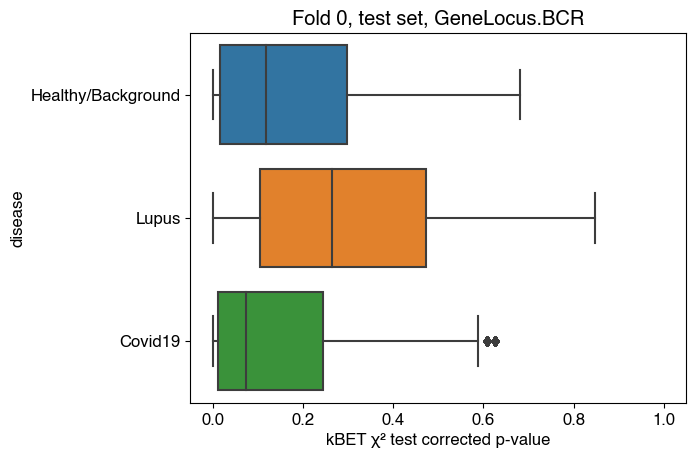

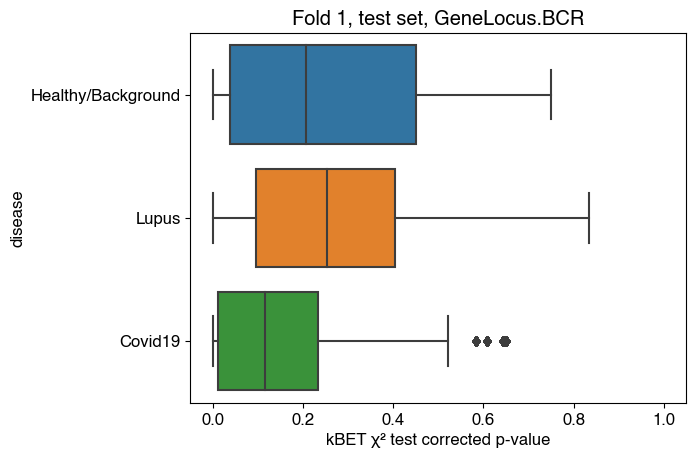

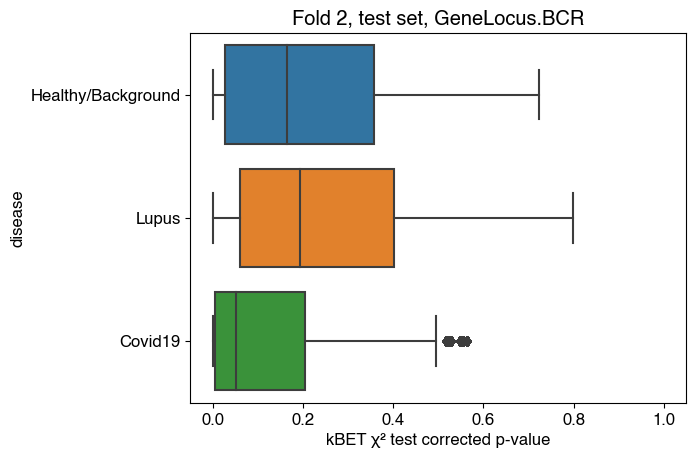

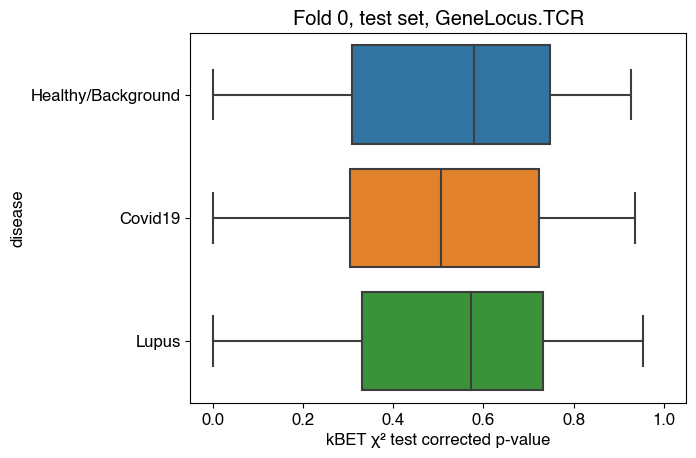

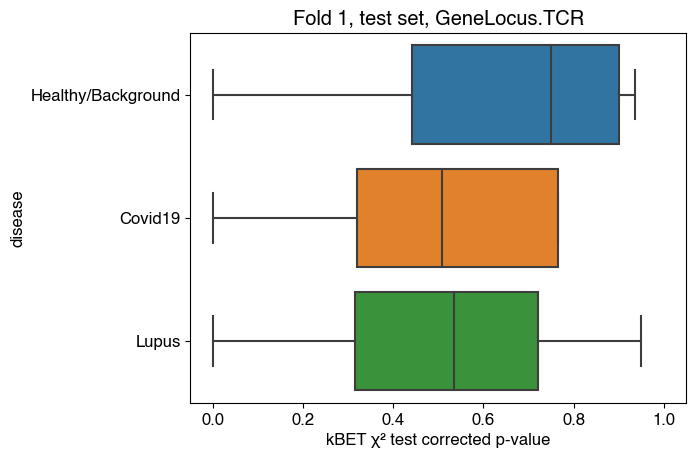

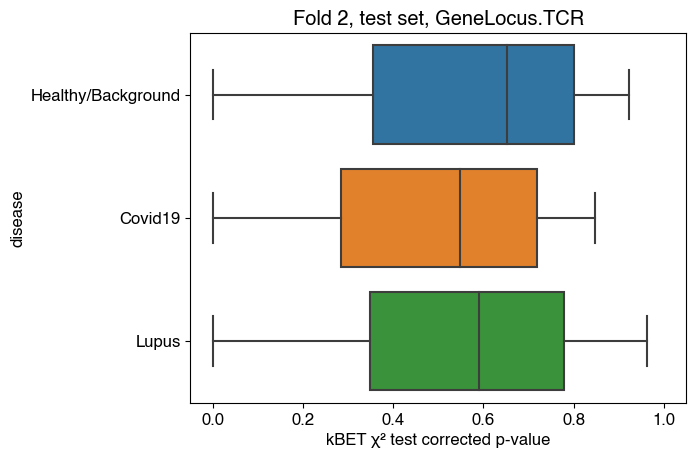

In [7]:
kbet_results = kdict()
for gene_locus in config.gene_loci_used:
    for fold_id in config.cross_validation_fold_ids:
        logger.info(f"Running on {gene_locus}, fold {fold_id}-{fold_label}")
        adata = io.load_fold_embeddings(
            fold_id=fold_id,
            fold_label=fold_label,
            gene_locus=gene_locus,
            target_obs_column=target_obs_column,
        )
        # PCA was precomputed with 50 dims
        assert adata.obsm["X_pca"].shape[1] == 50
        print(adata.obs.groupby([label_key, batch_key], observed=True).size())

        # Plot kBET on each disease label
        (
            average_rejection_rate_overall,
            average_rejection_rates_by_label,
            corrected_p_values_by_label,
        ) = kbet(
            adata=adata,
            batch_key=batch_key,
            label_key=label_key,
            significance_threshold_alpha=0.05,
        )

        # Save results
        # reformat dict as dataframe
        average_rejection_rates_by_label = (
            pd.Series(average_rejection_rates_by_label)
            .rename("average_rejection_rate")
            .rename_axis(index=label_key)
            .reset_index()
            .assign(fold_id=fold_id, fold_label=fold_label, gene_locus=gene_locus.name)
        )
        kbet_results[gene_locus, fold_id, fold_label] = (
            average_rejection_rate_overall,
            average_rejection_rates_by_label,
        )

        # Print results
        print(
            f"kBET result for {gene_locus}, fold {fold_id}-{fold_label}: {average_rejection_rate_overall:0.5f} average of average rejection rate by label"
        )
        print("Average rejection rates for each label")
        display(average_rejection_rates_by_label)

        # Plot per-sequence corrected p values
        fig, ax = plt.subplots()
        sns.boxplot(
            data=pd.concat(
                [
                    pd.DataFrame(v, columns=[xlabel]).assign(**{ylabel: k})
                    for k, v in corrected_p_values_by_label.items()
                ]
            ),
            x=xlabel,
            y=ylabel,
            ax=ax,
        )
        plt.title(f"Fold {fold_id}, {fold_label} set, {gene_locus}")
        plt.xlim(-0.05, 1.05)

        # Clear cache before moving onto next fold
        io.clear_cached_fold_embeddings()
        gc.collect()

        print("*" * 60)

# Review all results

In [8]:
# Show all results as a table
all_results_overall = pd.DataFrame.from_records(
    dict(
        gene_locus=gene_locus.name,
        fold_id=fold_id,
        fold_label=fold_label,
        average_rejection_rate_overall=average_rejection_rate_overall,
    )
    for (gene_locus, fold_id, fold_label), (
        average_rejection_rate_overall,
        _,
    ) in kbet_results.items()
)
all_results_overall

,gene_locus,fold_id,fold_label,average_rejection_rate_overall
0,BCR,0,test,0.324649
1,BCR,1,test,0.275988
2,BCR,2,test,0.341952
3,TCR,0,test,0.051084
4,TCR,1,test,0.049095
5,TCR,2,test,0.050770


In [9]:
all_results_overall.to_csv(
    config.paths.output_dir
    / "kbet_batch_evaluation.overall_results_by_genelocus_and_fold.tsv",
    sep="\t",
    index=None,
)

In [10]:
all_results_overall = pd.read_csv(
    config.paths.output_dir
    / "kbet_batch_evaluation.overall_results_by_genelocus_and_fold.tsv",
    sep="\t",
)
all_results_overall

,gene_locus,fold_id,fold_label,average_rejection_rate_overall
0,BCR,0,test,0.324649
1,BCR,1,test,0.275988
2,BCR,2,test,0.341952
3,TCR,0,test,0.051084
4,TCR,1,test,0.049095
5,TCR,2,test,0.050770


In [11]:
# Remember: 0 means optimal batch mixing and 1 means low batch mixing
# For each locus+fold, we took average across all cells within each label, then average across all labels
# And now we can report average +/- std across folds by locus+disease, or by locus, or overall

In [12]:
# agg by locus
all_results_overall.groupby("gene_locus")["average_rejection_rate_overall"].agg(
    ["mean", "std"]
)

,mean,std
gene_locus,,
BCR,0.314196,0.034202
TCR,0.050316,0.001069


In [13]:
# agg over all
all_results_overall["average_rejection_rate_overall"].agg(["mean", "std"])

mean    0.182256
std     0.146144
Name: average_rejection_rate_overall, dtype: float64

In [14]:
# All results at per-label specificity (i.e. before we take average over all labels)
all_results_per_label = pd.concat(
    (
        average_rejection_rates_by_label
        for (_, average_rejection_rates_by_label) in kbet_results.values()
    ),
    axis=0,
).reset_index(drop=True)
all_results_per_label

,disease,average_rejection_rate,fold_id,fold_label,gene_locus
0,Healthy/Background,0.362727,0,test,BCR
1,Lupus,0.164288,0,test,BCR
2,Covid19,0.446931,0,test,BCR
3,Healthy/Background,0.273227,1,test,BCR
4,Lupus,0.172976,1,test,BCR
5,Covid19,0.381760,1,test,BCR
6,Healthy/Background,0.307194,2,test,BCR
7,Lupus,0.223200,2,test,BCR
8,Covid19,0.495463,2,test,BCR
9,Healthy/Background,0.070744,0,test,TCR


In [15]:
all_results_per_label.to_csv(
    config.paths.output_dir
    / "kbet_batch_evaluation.per_label_results_by_genelocus_and_fold.tsv",
    sep="\t",
    index=None,
)

In [16]:
all_results_per_label = pd.read_csv(
    config.paths.output_dir
    / "kbet_batch_evaluation.per_label_results_by_genelocus_and_fold.tsv",
    sep="\t",
)
all_results_per_label

,disease,average_rejection_rate,fold_id,fold_label,gene_locus
0,Healthy/Background,0.362727,0,test,BCR
1,Lupus,0.164288,0,test,BCR
2,Covid19,0.446931,0,test,BCR
3,Healthy/Background,0.273227,1,test,BCR
4,Lupus,0.172976,1,test,BCR
5,Covid19,0.381760,1,test,BCR
6,Healthy/Background,0.307194,2,test,BCR
7,Lupus,0.223200,2,test,BCR
8,Covid19,0.495463,2,test,BCR
9,Healthy/Background,0.070744,0,test,TCR


In [17]:
all_results_per_label.groupby(["gene_locus", target_obs_column.value.obs_column_name])[
    "average_rejection_rate"
].agg(["mean", "std"])

mean       std
gene_locus disease                               
BCR        Covid19             0.441385  0.057054
           Healthy/Background  0.314383  0.045181
           Lupus               0.186821  0.031803
TCR        Covid19             0.047633  0.002320
           Healthy/Background  0.066089  0.005658
           Lupus               0.037227  0.003451

In [18]:
all_results_per_label.groupby(["gene_locus"])["average_rejection_rate"].agg(
    ["mean", "std"]
)

,mean,std
gene_locus,,
BCR,0.314196,0.117164
TCR,0.050316,0.013136


In [19]:
all_results_per_label["average_rejection_rate"].agg(["mean", "std"])

mean    0.182256
std     0.158030
Name: average_rejection_rate, dtype: float64